### Goal ###
Find the nearest [California Data Exchange Center](https://cdec.water.ca.gov/) weather station to each of our California bins. This information will be used to assign each bin weather variable values.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool
%matplotlib inline
%load_ext memory_profiler

Lets load the station locations and the bins and take a look.

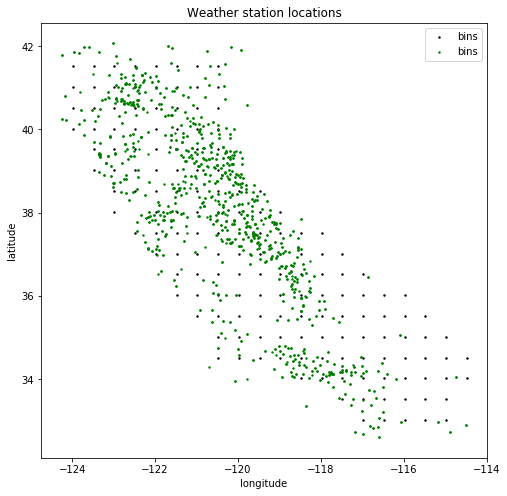

In [2]:
stations = pd.read_csv('../data/CDEC_weather_station_data/target_stations.csv')

# Rename columns to project standards
stations.columns = ['station','elevation', 'lat', 'long']

# There is one station which has coordinates 0, 0. Get rid of it
stations = stations[stations.long != 0]

bins = pd.read_csv('../data/spatial_data/california_bins.csv')

plt.rcParams["figure.figsize"] = (8,8)
plt.scatter(x = bins['long'], y = bins['lat'], color = 'black', s = 2, label = 'bins')
plt.scatter(x = stations['long'], y = stations['lat'], color = 'green', s = 2, label = 'bins')
plt.axis('equal')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('Weather station locations')
plt.legend()
plt.show()

Since we have many bins which do not contain a weather monitoring station, the next step is to fill in their values from the nearest station. First find the nearest station to each bin. To do this we will use scipy.spatial.

In [3]:
bin_array = np.column_stack([bins['long'], bins['lat']])
station_array = np.column_stack([stations['long'], stations['lat']])

In [4]:
from scipy import spatial

station_tree = spatial.cKDTree(station_array)
dist, indexes = station_tree.query(bin_array)

nearest_station_names = []
for index in indexes:
    nearest_station_names.append(stations.iloc[index, 0])
    
bins['nearest_station_name'] = nearest_station_names
bins.head()

,long,lat,nearest_station_name
0,-116.98,33.02,ELC
1,-116.48,33.02,JUL
2,-115.98,33.02,FIS
3,-115.48,33.02,CAU
4,-114.98,33.02,CAU


Starting with the temperature dataset as a test case, now we will make an hourly time series spanning from 2006 to 2016 and assign each bin a temprature from it's nearest station each hour. 

In [17]:
# Annoying, but here goes...
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#temp_data = pd.read_csv("../data/training_data/weather_data/TEMP_1mo.csv", usecols = ["STATION_ID", "OBS_DATE", "VALUE"], index_col = "OBS_DATE", dtype = {"STATION_ID" : "object", "VALUE" : "int"}, parse_dates=['OBS_DATE'])
temp_data = pd.read_csv("../data/training_data/weather_data/TEMP_1mo.csv", parse_dates=['OBS_DATE'], usecols = ["STATION_ID", "OBS_DATE", "VALUE"], index_col = "OBS_DATE")
temp_data = temp_data[temp_data.VALUE != '---']
temp_data.head()

,STATION_ID,VALUE
OBS_DATE,,
2015-01-01 23:00:00,ACN,31
2015-01-02 00:00:00,ACN,30
2015-01-02 01:00:00,ACN,29
2015-01-02 02:00:00,ACN,30
2015-01-02 03:00:00,ACN,33


In [18]:
temp_data['VALUE'].dtype

dtype('int64')

Plan here is to multiindex the weather data by station and datetime so when building the final training dataset each bin can ask for data from its nearest station at a particular time. Lets trim some of the fat first. In order to make the weather data more managable, we will resample with a 6 hour resolution. This will effectivly make the dataset 6x smaller.

In [19]:
stations = temp_data['STATION_ID'].unique().tolist()

In [20]:
n_threads = 14

def downsample_timeseries(group):
    group = group.sort_index()
    group.loc[:,'resampled_value'] = group.VALUE.rolling('6H').mean()
    group = group.drop(['VALUE'], axis = 1)
    return group.iloc[0::12, :]

def group_timeseries_data(stations):
    data = temp_data.loc[temp_data['STATION_ID'].isin(stations)]
    grouped_data = data.groupby('STATION_ID')
    return grouped_data.apply(downsample_timeseries)
    
def parallelize(stations, func, n_cores = n_threads):
    '''Parallelizes downsampling, takes list of stations and
    splits up the downsampling fuction over avalibile threads'''
    stations_split = np.array_split(stations, n_cores)
    pool = Pool(n_cores)
    result = pd.concat(pool.map(func, stations_split))
    pool.close()
    pool.join()
    return result
    
binned_temp_data = parallelize(stations, group_timeseries_data)
binned_temp_data = binned_temp_data.reset_index(level = 0, drop = True)
binned_temp_data = binned_temp_data.set_index(['STATION_ID'], append = True)
binned_temp_data

,,resampled_value
OBS_DATE,STATION_ID,
2015-01-01 23:00:00,ACN,31.000000
2015-01-02 05:00:00,ACN,30.363636
2015-01-02 11:00:00,ACN,38.909091
2015-01-02 17:00:00,ACN,51.454545
2015-01-02 23:00:00,ACN,34.909091
...,...,...
2015-01-30 23:00:00,WWS,54.833333
2015-01-31 11:00:00,WWS,60.333333
2015-01-31 23:00:00,WWS,49.500000


In [21]:
binned_temp_data['resampled_value'].dtype

dtype('float64')

In [22]:
#binned_temp_data.to_csv('../data/training_data/weather_data/TEMP_1yr_binned_6hr.csv')

In [23]:
time_series = pd.date_range("2015-01-01 23:00:00", "2015-02-01 23:00:00", freq = "6H")
time_series = time_series.to_series()
time_series.head()

2015-01-01 23:00:00   2015-01-01 23:00:00
2015-01-02 05:00:00   2015-01-02 05:00:00
2015-01-02 11:00:00   2015-01-02 11:00:00
2015-01-02 17:00:00   2015-01-02 17:00:00
2015-01-02 23:00:00   2015-01-02 23:00:00
Freq: 6H, dtype: datetime64[ns]

Now we make a dataframe of 'noxels' or n-dimentional voxels. Each row will be a bin at a specific time. Once we have this dataframe, we can go back though and assign weather variable values to each noxel.

In [41]:
def apply_to_bins(time_series, bins):
    return bins.assign(time = time_series)

%memit noxels = pd.concat(time_series.apply(apply_to_bins, args = (bins,)).tolist())
noxels.head()

peak memory: 215.47 MiB, increment: 0.00 MiB


,long,lat,nearest_station_name,time
0,-116.98,33.02,ELC,2015-01-01 23:00:00
1,-116.48,33.02,JUL,2015-01-01 23:00:00
2,-115.98,33.02,FIS,2015-01-01 23:00:00
3,-115.48,33.02,CAU,2015-01-01 23:00:00
4,-114.98,33.02,CAU,2015-01-01 23:00:00


In [42]:
def try_except(row):
    try:
        return binned_temp_data.loc[row['time'], row['nearest_station_name']]
    except:
        return np.nan

noxels['temp'] = noxels.apply(lambda row: try_except(row), axis = 1)
noxels = noxels.dropna()
noxels['temp'] = noxels['temp'].str[0]
noxels.head()

,long,lat,nearest_station_name,time,temp
1,-116.48,33.02,JUL,2015-01-01 23:00:00,23.0
2,-115.98,33.02,FIS,2015-01-01 23:00:00,45.0
3,-115.48,33.02,CAU,2015-01-01 23:00:00,39.0
4,-114.98,33.02,CAU,2015-01-01 23:00:00,39.0
5,-117.48,33.52,BEC,2015-01-01 23:00:00,42.0


In [43]:
noxels.to_csv('../data/training_data/noxels.csv', index = False)

OK, so, working to a first approximation. I am worried that we a loosing a bunch of data somewhere. Lets check some lengths and see. If we filled every bin with a temperature value, then we should have bins x time_series rows in our data file...

In [48]:
round(len(noxels) / (len(bins) * len(time_series)), 2)

0.48

Looks like we only caught about half of the data. My brain is toast for the night, but here are the next steps:
1. Figure out why only half the noxels are getting data - my hunch is that is has something to do with cell In \[20\] in the downsample_timeseries function. Grabbing values on a regular interval and hoping it corresponds to 6 hr. time blocks seems stupid. What if we are missing data?
2. Parralize cell 42? We are going to need to to handle **way** more data than this and it's noticeably slow already.